<a href="https://colab.research.google.com/github/aashray18521/CIFAR-10-object-recognition/blob/master/TPU_Copy_of_CIFAR10_Keras_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10 Classification: TPU Version

The goal of this notebook is to implement a simple conv net to classify CIFAR10 images using TPU and compare its training time against GPU on local workstation and Colab GPU.

In [0]:
import os
from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [2]:
# check tensorflow version, we want the one that support eager mode
tf.__version__

'1.12.0'

In [0]:
# Turn on the eager mode
#tf.enable_eager_execution()

In [4]:
# Check if eager execution mode is on
tf.executing_eagerly()

False

# Dataset

Load CIFAR10 dataset

In [5]:
from tensorflow.keras.datasets import cifar10, mnist

(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
print('x_train_full shape: {}, y_train_full.shape: {}'
      .format(x_train_full.shape, y_train_full.shape))
print('x_test shape: {}, y_test.shape: {}'.format(x_test.shape, y_test.shape))

170500096/170498071 [==============================] - 40s 0us/step
x_train_full shape: (50000, 32, 32, 3), y_train_full.shape: (50000, 1)
x_test shape: (10000, 32, 32, 3), y_test.shape: (10000, 1)


In [6]:
y_train_full = y_train_full.reshape(y_train_full.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)
print('y_train_full shape: {}, y_test shape: {}'
      .format(y_train_full.shape, y_test.shape))

y_train_full shape: (50000,), y_test shape: (10000,)


In [7]:
# create validation set
split = 0.2
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42)
print('x_train: {}, y_train: {}, x_val: {}, y_val: {}'
      .format(x_train.shape, y_train.shape, x_val.shape, y_val.shape))

x_train: (40000, 32, 32, 3), y_train: (40000,), x_val: (10000, 32, 32, 3), y_val: (10000,)


Lets plot 25 random images to get some idea about the dataset

In [0]:
# pick 25 random images and plot
idxs = np.random.randint(x_train.shape[0], size=25)
images = x_train[idxs]
labels = y_train[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

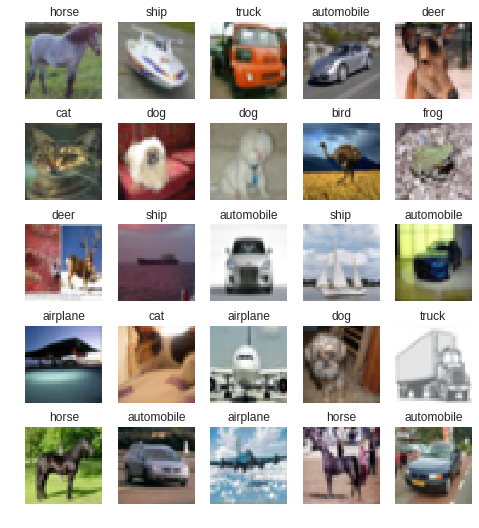

In [9]:
fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])

plt.show()

In [0]:
# Using Dataset
# def scale(x, min_val=0.0, max_val=255.0):
#   x = tf.to_float(x)
#   return tf.div(tf.subtract(x, min_val), tf.subtract(max_val, min_val))

# convert to dataset
# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_ds = train_ds.map(lambda x, y: (scale(x), tf.one_hot(y, 10))).shuffle(10000)

# test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# test_ds = test_ds.map(lambda x, y: (scale(x), tf.one_hot(y, 10))).shuffle(10000)

# def train_generator(batch_size):
#   while True:
#     images, labels = train_ds.batch(batch_size).make_one_shot_iterator().get_next()
#     yield images, labels

In [0]:
def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, x_train.shape[0] - batch_size)
    yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]

# Build a model

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('selu')(BatchNorm)
        Conv2D_3_3 = SeparableConv2D(int(num_filter*compression), kernel_size = (3, 3), data_format=None, padding='same', depth_multiplier=1, activation='selu', use_bias=False, kernel_initializer='glorot_uniform')(relu)
#         Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,1), use_bias=False ,padding='same')(relu)
#         Conv2D_3_3 = Conv2D(int(num_filter*compression), (1,3), use_bias=False ,padding='same')(Conv2D_3_3)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('selu')(BatchNorm)
    Conv2D_BottleNeck = SeparableConv2D(int(num_filter*compression), kernel_size = (1, 1), padding='same', data_format=None, depth_multiplier=1, activation='selu', use_bias=False, kernel_initializer='glorot_uniform')(relu)
#     Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('selu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [0]:
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.python.keras.layers import Concatenate

img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

compression= 1

num_classes=10

num_filter = 32
dropout_rate = 0.2
l = 12

input = Input(shape=(img_height, img_width, channel,))
BatchNorm = BatchNormalization()(input)
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same', dilation_rate=(1, 1))(BatchNorm)
# First_Conv2D = Conv2D(num_filter, (1,3), use_bias=False ,padding='same')(First_Conv2D)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [16]:
# from keras.models import Model, Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python import keras
# from tensorflow.python.keras.models import Sequential, Model
# from tensorflow.python.keras.layers import Dense, Activation

model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   864         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation

In [17]:
print(type(model))

<class 'tensorflow.python.keras.engine.training.Model'>


In [0]:
# from tensorflow.python.keras.optimizers import SGD
# model.compile(loss='categorical_crossentropy',
#               optimizer=SGD(momentum=0.99, nesterov=True),
#               metrics=['accuracy'])

In [0]:
# model = keras.estimator.model_to_estimator(keras_model=model)

In [0]:
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
# from keras.layers import Concatenate
# from keras.models import Model, Sequential

# img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]


# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='elu', input_shape=(img_height, img_width, channel,), dilation_rate=(1, 1)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
# model.add(tf.keras.layers.SeparableConv2D(64, (3,3), padding='same', dilation_rate=(1, 1), activation='elu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
# model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='elu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='elu'))
# model.add(tf.keras.layers.Dropout(0.4))
# model.add(tf.keras.layers.Dense(10, activation='elu'))
# model.add(tf.keras.layers.Activation('softmax'))
# model.summary()

In [21]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu="grpc://" + os.environ['COLAB_TPU_ADDR'])))



INFO:tensorflow:Querying Tensorflow master (b'grpc://10.87.56.218:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2072717185663826064)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3538847393777037590)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 17167026397057162672)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4319449162673151659)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1610987842305295286)
INFO:tensorflow:*** Available Device: _DeviceA

# Train

Train the model on TPU

In [0]:
# from google.colab import files
# src = list(files.upload().values())[0]
# open('clr_callback.py','wb').write(src)
# from clr_callback import *

In [0]:
# from clr_callback import *

In [0]:
# clr_triangular = CyclicLR(mode='triangular2', step_size=195, base_lr=0.01, max_lr=0.1)

In [0]:
# # determine Loss function and Optimizer
# model.compile(loss='categorical_crossentropy',
#               optimizer=SGD(momentum=0.99, nesterov=True),
#               metrics=['accuracy'])

In [0]:
# , callbacks=[clr_triangular])

In [0]:
# tflearn.optimizers.SGD
# tf.train.GradientDescentOptimizer
# tf.keras.optimizers.SGD 

tpu_model.compile(
    optimizer= tf.train.AdamOptimizer(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

In [28]:
batch_size=1024
start = time()
history = tpu_model.fit_generator(
    train_gen(batch_size), epochs=100, 
    steps_per_epoch=np.ceil(x_train.shape[0]/batch_size),
    validation_data = (x_val, y_val),
)
end = time()

Epoch 1/100
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 87.51603078842163 secs
INFO:tensorflow:Setting weights on TPU model.
39/40 [============================>.] - ETA: 4s - loss: 1.7959 - sparse_categorical_accuracy: 0.3539INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping p

In [29]:
print('Total training time {} seconds'.format(end - start))

Total training time 4722.2107973098755 seconds


In [0]:
def plot(losses, accuracies, subplot_title):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
  
  ax1.plot(losses)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  
  ax2.plot(accuracies)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
    
  plt.show()

### Plot Loss and Accuracy

Lets see how did we do on training and validation sets

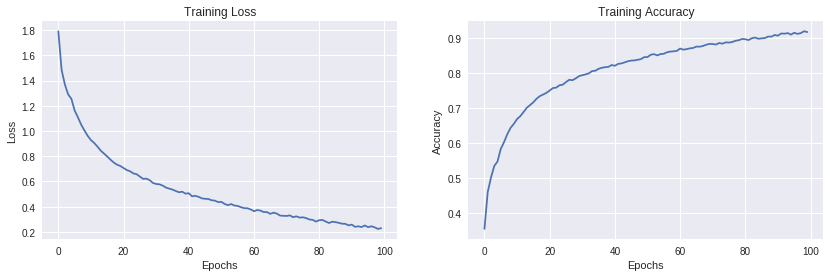

In [31]:
# Training
plot(history.history['loss'], 
     history.history['sparse_categorical_accuracy'], 
     subplot_title=['Training Loss', 'Training Accuracy']
    )

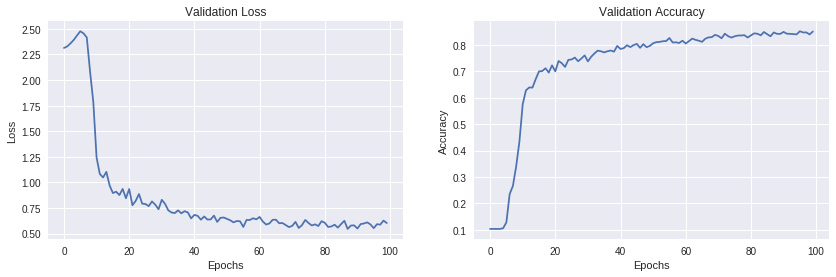

In [32]:
# Validation
plot(history.history['val_loss'], 
     history.history['val_sparse_categorical_accuracy'], 
     subplot_title=['Validation Loss', 'Validation Accuracy']
    )

# Test accuracy

Next, we plot the model predictions on test set

In [33]:
cpu_model = tpu_model.sync_to_cpu()

INFO:tensorflow:Copying TPU weights to the CPU


In [0]:
idxs = np.random.randint(x_test.shape[0], size=25)
images = x_test[idxs]
true_labels = y_test[idxs]

preds = np.argmax(cpu_model.predict(images), axis=1)

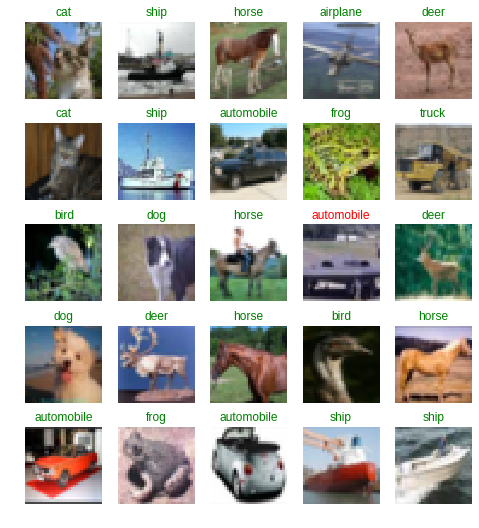

In [35]:
fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = preds[i]
  color = 'g' if idx == true_labels[i] else 'r'
  ax.set_title(classnames[idx], color=color)

plt.show()

Now that we've got the basic model working, you can try improving its accuracy. 
For example, you can try :
* preprocessing
* transfer learning
* learning rates using learning rate finder
* different network architecture


You can try to match/beat the CIFAR10 accuracy listed on this <a href="http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130">page</a>.